In [1]:
import os
import glob
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

import analyze2p.decoding as dec

In [3]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'
# ----------------------------------------

In [4]:
%matplotlib notebook

In [5]:
experiment = 'blobs'
trial_epoch = 'stimulus'
responsive_test='ROC'
# ----------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
# CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
#                 if not meta.query('@va == visual_area and @dk == datakey').empty])
# # Neural data
# NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
#                       response_type=response_type, trial_epoch=trial_epoch,
#                       responsive_test=responsive_test, 
#                       responsive_thr=responsive_thr)
# if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
#     NDATA0['experiment'] = experiment 

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets


In [6]:
C_value=1.0
test_split=0.2
cv_nfolds=5

chance_level = 1/8. if experiment=='gratings' else 0.5

In [154]:
analysis_type='by_ncells'
test_type='size_single'
class_name = 'morphlevel'
match_rfs = False
overlap_thr= 0.0

test_str = 'default' if test_type is None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, '%s' % test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)

## Output dirs

In [155]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
if overlap_thr is not None and isinstance(overlap_thr, (list, np.ndarray)) or match_rfs:
    curr_dst_dir = os.path.join(basedir, 'controls')
else:
    curr_dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES')

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00
dff-ROC__stimulus__overlap0.00__C1.00


## Check input data

In [156]:
import _pickle as pkl
input_id = '__'.join(aggr_id.split('__')[0:-1])
input_files = glob.glob(os.path.join(basedir, 'files', 
                                     'inputcells-*_%s.pkl' % input_id))
#input_files = glob.glob(os.path.join(basedir, 'files', 'inputcells*.pkl'))
print(len(input_files))
#input_fpath = input_files[0]
i_=[]
for ipath in input_files:
    with open(ipath, 'rb') as f:
        icells = pkl.load(f)
    i_.append(icells)
inputcells = pd.concat(i_, axis=0)

0


ValueError: No objects to concatenate

In [42]:
inputcells.columns

Index(['datakey', 'cell', 'x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset',
       'amplitude', 'r2', 'std_x', 'std_y', 'fwhm_avg', 'std_avg', 'area',
       'fx', 'fy', 'ratio_xy', 'theta_c', 'theta_Mm_deg', 'major_axis',
       'minor_axis', 'anisotropy', 'theta_Mm_c', 'aniso_index', 'visual_area',
       'experiment', 'global_ix'],
      dtype='object')

<IPython.core.display.Javascript object>


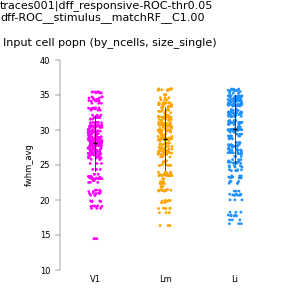

Text(0.01, 0.85, 'Input cell popn (by_ncells, size_single)')

In [59]:
fig, ax = pl.subplots(figsize=(3,3))

sns.stripplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, s=2,
              palette=area_colors, order=visual_areas, zorder=-1000)
sns.pointplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
             color='k', order=visual_areas, scale=0.5, errwidth=0.5, join=False,
             markers='_', zorder=1000, ci='sd', estimator=np.median)
ax.set_ylim((10, 40))
pl.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=0.8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
# sns.boxplot(x='visual_area', y='fwhm_avg', data=inputcells, ax=ax, 
#              color='w', order=visual_areas, fliersize=0)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
sns.despine(bottom=True, trim=True)
fig.text(0.01, 0.85, 'Input cell popn (%s, %s)' % (analysis_type, test_type), 
         fontsize=8)


In [19]:
aggr_id

'dff-ROC__stimulus__matchRF__C1.00'

## Load

In [157]:
experiment = 'gratings' if class_name=='ori' else 'blobs'
iterdf, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=None,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
if match_rfs and (responsive_test=='ROC'):
    iterdf = iterdf[iterdf.n_cells<=96]
    

(Li) Found 9 paths
(Lm) Found 9 paths
(V1) Found 10 paths
    checking for break-corrs
(Li) Found 0 paths
(Lm) Found 0 paths
(V1) Found 0 paths


In [158]:
grouper = ['visual_area', 'condition', 'iteration']
mean_df0 = dec.average_within_iterations_by_ncells(iterdf, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 

if test_type is not None:
    score_table = mean_df0[ (mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells', 'novel'])\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'novel'], columns='n_cells')
else:
    score_table = mean_df0[(mean_df0.condition=='data')]\
            .groupby([ 'visual_area', 'n_cells'])\
            .mean()['heldout_test_score'].reset_index().pivot_table(index='visual_area', columns='n_cells')
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

['visual_area', 'condition', 'iteration', 'n_cells', 'novel']
EXP: blobs (class=morphlevel): dff-ROC__stimulus__overlap0.00__C1.00


heldout_test_score                                          \
n_cells                          1         2         4         8         16    
visual_area novel                                                              
Li          False           0.525020  0.544831  0.570656  0.598471  0.615770   
            True            0.523391  0.537498  0.556059  0.582581  0.598081   
Lm          False           0.534767  0.545600  0.561500  0.589667  0.614267   
            True            0.517668  0.522439  0.531990  0.541983  0.552917   
V1          False           0.542438  0.560095  0.589200  0.619867  0.653233   
            True            0.520938  0.532741  0.551360  0.564369  0.583514   

                                                                     
n_cells                 32        64        96        128       256  
visual_area novel                                                    
Li          False  0.645717  0.724856  0.772612  0.808873       NaN  
            True   0.623237  0.674318  0.707698  0.728900       NaN  
Lm          False  0.640900  0.702533  0.743033  0.776400       NaN  
            True   0.563745  0.595391  0.614047  0.631041       NaN  
V1          False  0.694700  0.768233  0.815267  0.844700  0.899833  
            True   0.606193  0.648800  0.678997  0.698538  0.737433

In [160]:
max_ncells=96
n_iters = iterdf['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells\
               and s!=169]
xlabels = [1, 32, 96, max_ncells]
grouper = ['visual_area', 'condition', 'iteration']

mean_df = mean_df0[mean_df0['n_cells'].isin(sample_sizes)]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

novel: [False  True]
conditions: ['data' 'shuffled']


In [161]:
max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
print(max_ncells)

96


<IPython.core.display.Javascript object>


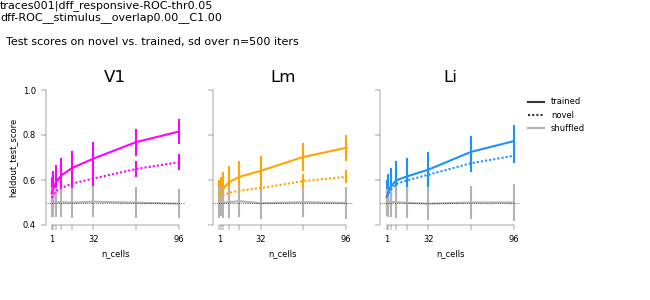

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 trained_v_novel_byncells__dff-ROC__stimulus__overlap0.00__C1.00


In [163]:
plotd = mean_df[mean_df['n_cells']<=max_ncells].copy()
plotd['novel_labels'] = None
plotd.loc[plotd['novel'], 'novel_labels'] = 'novel'
plotd.loc[~plotd['novel'], 'novel_labels'] = 'trained'
#cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
cond_styles = {'trained': '', 'novel': (1,1)}

%matplotlib notebook
metric='heldout_test_score'
if analysis_type=='by_ncells':
    fig, axn = pl.subplots(1,3, figsize=(6.5, 3), sharex=True, sharey=True)
    for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
        ai = visual_areas.index(va)
        ax=axn[ai]; ax.set_title(va);
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='data'], ax=ax,
                style='novel_labels', dashes=cond_styles, ci='sd', err_style='bars',
                    color=area_colors[va])
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='shuffled'],ax=ax,
                color=[0.7]*3, ci='sd', err_style='bars', label='shuffled', 
                    linestyle='-')
        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.07, right=0.8, bottom=0.25, top=0.7,
                      wspace=0.2)
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

fig.text(0.01, 0.85, 'Test scores on novel vs. trained, sd over n=%i iters' % n_iters,
        fontsize=8)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

figname = 'trained_v_novel_byncells__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
figname = 'trained_v_novel_byncells__%s' % aggr_id
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(curr_dst_dir, figname)

In [159]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00'

<IPython.core.display.Javascript object>


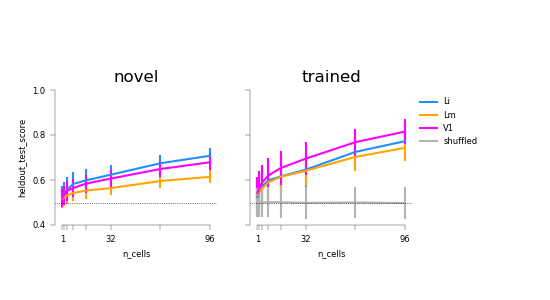

In [164]:

%matplotlib notebook
metric='heldout_test_score'
if analysis_type=='by_ncells':
    fig, axn = pl.subplots(1,2, figsize=(5.5, 3), sharex=True, sharey=True)
    for ai, (cond, df_) in enumerate(plotd.groupby(['novel_labels'])):
        ax=axn[ai]; ax.set_title(cond);
        sns.lineplot(x='n_cells', y=metric, data=df_[df_.condition=='data'], ax=ax,
                    ci='sd', err_style='bars',
                    hue='visual_area', palette=area_colors)
        sns.lineplot(x='n_cells', y=metric, ax=ax,
                    data=df_[df_.condition=='shuffled'],
                    color=[0.7]*3, ci='sd', err_style='bars', label='shuffled', 
                    linestyle='-')
        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.1, right=0.75, bottom=0.25, top=0.7,
                      wspace=0.2)
for ax in axn:
    ax.set_yticks(np.linspace(0.4, 1, 4))
    ax.set_ylim([0.4,1])
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
sns.despine(trim=True)

In [77]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/controls'

#### Discrimination performance (train config = test config)

<IPython.core.display.Javascript object>


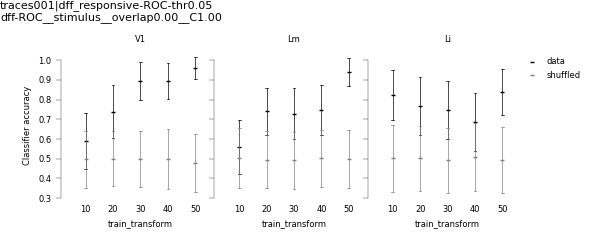

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/axisgrid.py:648: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 trainconfigs__dff-ROC__stimulus__overlap0.00__C1.00


In [165]:
#max_ncells = 96
curr_ncells=max_ncells

traind = iterdf[~(iterdf.novel) & (iterdf['n_cells']==curr_ncells)].copy()

fg = sns.FacetGrid(traind, col='visual_area', col_order=visual_areas, 
                   height=2.5, aspect=0.8)
fg.map(sns.pointplot, 'train_transform', 'heldout_test_score', 'condition', 
      palette={'data': 'k', 'shuffled': 'gray'}, markers='_', ci='sd',
       capsize=0.1, scale=0.5, errwidth=0.5, join=False)
fg.set_titles(col_template="{col_name}")

sns.despine(bottom=True, offset=8, trim=True)
for ai,ax in enumerate(fg.axes.flat):
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xticklabels([int(s) for s in sorted(traind['train_transform'].unique())])
    if ai==0:
        ax.set_ylabel('Classifier accuracy')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

pl.subplots_adjust(left=0.12, bottom=0.2, right=0.86, top=0.8)
pplot.label_figure(fg.fig, '%s\n%s' % (data_id, aggr_id))

figname = 'trainconfigs__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Trained vs Novel, by training condition

<IPython.core.display.Javascript object>


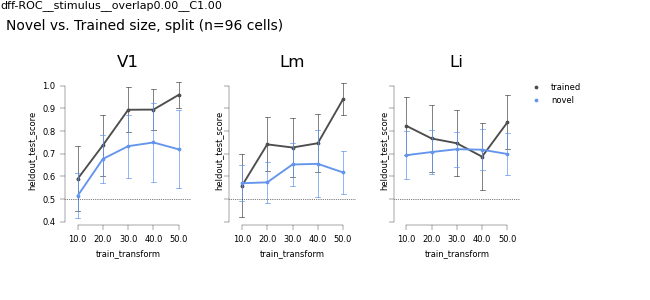

In [166]:
plotd = iterdf[iterdf['n_cells']==max_ncells].copy()
plotd['novel_labels'] = None
plotd.loc[plotd['novel'], 'novel_labels'] = 'novel'
plotd.loc[~plotd['novel'], 'novel_labels'] = 'trained'
cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}

metric = 'heldout_test_score'
fig, axn = pl.subplots(1,3, figsize=(6.5, 3), sharex=True, sharey=True)
for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]
    ax.set_title(va)
    sns.pointplot(x='train_transform', y=metric, data=df_[df_.condition=='data'], 
            ax=ax, scale=0.5, palette=cond_colors, hue='novel_labels',
            ci='sd',capsize=0.2, errwidth=0.5, markers='.')
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75,
                  wspace=0.3)
sns.despine(trim=True)
pplot.label_figure(fig, aggr_id)
fig.text(0.01, 0.9, 'Novel vs. Trained size, split (n=%i cells)' % max_ncells)

figname = 'trained_v_novel_transforms__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

## Generalization score

In [167]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [168]:
va='Lm'
metric = 'heldout_test_score'
pass_list=[]
for (va, nc), g in mean_df.groupby(['visual_area', 'n_cells']):
    traindf = g[~(g.novel)].sort_values(by='iteration')

    ddf = traindf[traindf.condition=='data'][metric].reset_index(drop=True)
    ddf_s = traindf[traindf.condition=='shuffled'][metric].reset_index(drop=True)
    pass_ixs = ddf[ddf>ddf_s].index.to_numpy()
    len(pass_ixs)
    
    pass_list.append(mean_df[mean_df.iteration.isin(pass_ixs)])
    

In [169]:
passdf = pd.concat(pass_list, axis=0)

In [170]:
metric='heldout_test_score'
byiter_novel = dec.generalization_score_by_iter(passdf, max_ncells=max_ncells)

<IPython.core.display.Javascript object>


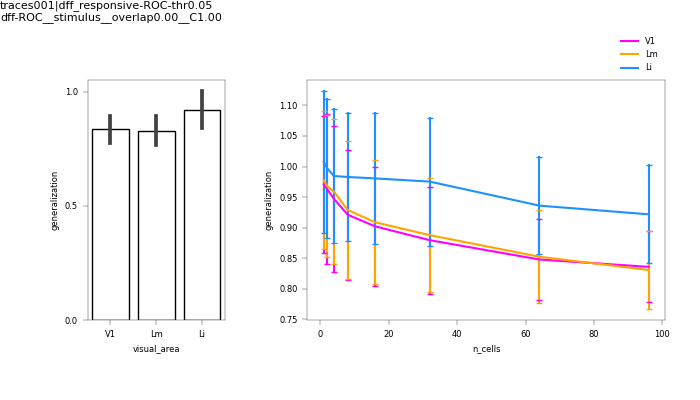

In [171]:
metric='generalization'
multi_comp_test='fdr_bh'
import matplotlib.gridspec as gridspec
fig = pl.figure(figsize=(7,4))
gs = gridspec.GridSpec(1,3) # figsize=(6,3))

ax=fig.add_subplot(gs[0])
sns.barplot(x='visual_area', y=metric, 
            data=byiter_novel[byiter_novel['n_cells']==max_ncells], ax=ax, ci='sd',
            order=visual_areas, edgecolor=('k', 'k', 'k'), facecolor='none')
ax.set_yticks(np.linspace(0.0, 1, 3))

ax=fig.add_subplot(gs[1:])
sns.lineplot(x='n_cells', y=metric, data=byiter_novel, ax=ax, 
             hue='visual_area', ci='sd',err_style='bars', err_kws={'capsize':2},
             palette=area_colors, hue_order=visual_areas)

# legend
ax.legend(bbox_to_anchor=(1., 1.), loc='lower right', frameon=False,
          title='', markerscale=0.5, fontsize=6)
pl.subplots_adjust(wspace=0.6, right=0.95, top=0.8, bottom=0.2)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))


In [172]:
# Calculate difference
byiter_data = mean_df[(mean_df['n_cells']<=max_ncells)
                     & (mean_df['condition']=='data')]
cols = ['visual_area', 'n_cells', 'iteration', 'train_transform', 'test_transform']
diffdf = byiter_data[cols].copy().reset_index(drop=True).drop_duplicates()
diffdf = diffdf.sort_values(by=['iteration', 'visual_area'])

byiter_data = byiter_data.sort_values(by=['iteration', 'visual_area'])
true_diffs = byiter_data[(~byiter_data.novel)]['heldout_test_score'].values\
            - byiter_data[(byiter_data.novel)]['heldout_test_score'].values
diffdf['difference'] = true_diffs

In [173]:
# Shuffle
currd = byiter_data[byiter_data['n_cells']==max_ncells].copy()
d_list = []
for i in range(n_iters):
    d_=[]
    for va, all_vals in currd.groupby(['visual_area']):
        half_vs = all_vals['heldout_test_score'].sample(n=n_iters, replace=False)
        unused = [v for v in all_vals.index if v not in half_vs.index]
        other_vs = all_vals.loc[unused, 'heldout_test_score'].sample(n_iters)
        diff_ = np.mean(half_vs.values - other_vs.values)
        df_ = pd.DataFrame({diff_}, index=[i], columns=[va])
        d_.append(df_)
    d_list.append(pd.concat(d_, axis=1))

shuff_diff = pd.concat(d_list, axis=0).stack().reset_index()\
                .rename(columns={0: 'difference', 'level_1': 'visual_area'})
shuff_diff['condition'] = 'shuffled'
shuff_diff = shuff_diff.drop('level_0', 1)

In [174]:
# combine
true_diff = pd.concat([pd.DataFrame({'difference': d['difference'].values}, 
                                     index=[va]*n_iters) \
    for va, d in diffdf[diffdf['n_cells']==max_ncells].groupby('visual_area')], 
                       axis=0) #.reset_index(drop=True)
true_diff['condition'] = 'data'
true_diff['visual_area'] = true_diff.index.tolist()
true_diff = true_diff.reset_index(drop=True)
diffs = pd.concat([true_diff, shuff_diff], axis=0)

<IPython.core.display.Javascript object>


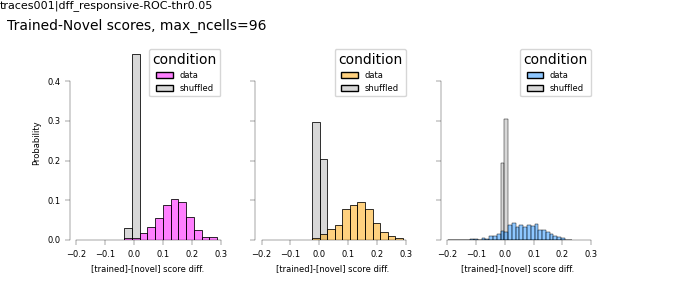

In [175]:
fig, axn = pl.subplots(1,3, figsize=(7, 3), sharex=True, sharey=True)
for vi, (va, df_) in enumerate(diffs.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    sns.histplot(x='difference', hue='condition', data=df_, ax=ax, alpha=0.5,
                palette={'data': area_colors[va], 'shuffled': [0.7]*3},
                 stat='probability', legend=True)
#                 cumulative=True, element='poly', fill=False)
    #true_mean = diffdf[diffdf.visual_area==va]['difference'].mean()
    #ax.axvline(x=true_mean, color=area_colors[va])
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85)
for ax in axn:
    ax.set_xlabel('[trained]-[novel] score diff.')
    #ax.legend(bbox_to_anchor=(1,1), loc='upper right', frameon=False, fontsize=6,)
    #          title='')
sns.despine(trim=True)

fig.text(0.01, 0.9, 'Trained-Novel scores, max_ncells=%i' % max_ncells)

pplot.label_figure(fig, data_id)

figname = 'hist_trained_vs_novel__%s' % aggr_id
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [176]:
import scipy.stats as spstats

In [177]:
data = [diffdf.loc[ids, 'difference'].values \
        for ids in diffdf.groupby('visual_area').groups.values()]

In [178]:
H, p = spstats.kruskal(*data)
H, p

(843.1297648571315, 8.254633527133946e-184)

In [179]:
# import scikit_posthocs as skp
# skp.post_(df, val_col='SepalWidth', group_col='Species', p_adjust = 'holm')

<IPython.core.display.Javascript object>


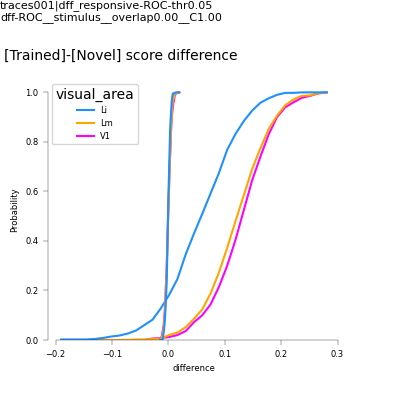

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 cumdist_trained_vs_novel_difference__dff-ROC__stimulus__overlap0.00__C1.00


In [180]:
fig, ax = pl.subplots(figsize=(4,4))
sns.histplot(x='difference', hue='visual_area', data=diffs[diffs.condition=='data'],
             ax=ax,
            cumulative=True, element='poly', fill=False,
            palette=area_colors, stat='probability', common_norm=False)
sns.histplot(x='difference', hue='visual_area', data=diffs[diffs.condition=='shuffled'],
             ax=ax, line_kws={'linestyle': ':'},
            cumulative=True, element='poly', fill=False,
            palette=area_colors, stat='probability', common_norm=False)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
sns.despine(trim=True)
fig.text(0.01, 0.85, '[Trained]-[Novel] score difference')
pl.subplots_adjust(bottom=0.15, top=0.8, left=0.12, right=0.85)
figname='cumdist_trained_vs_novel_difference__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
#figname='genratio_meanbyiter_split_traintransform__%s_%s_%s2' % (dset_str, shuffle_str, errstr)

pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

In [181]:
# results.loc[results['heldout_test_score']==0, 'heldout_test_score'] = 0.000000000001
metric='heldout_test_score'
drop_cols = ['fit_time', 'score_time', 'train_score', 'test_score']
cols = [c for c in iterdf.columns if c not in drop_cols]
data_df = iterdf[(iterdf.condition=='data')][cols].copy().reset_index(drop=True)

data_df['generalization'] = None
data_df['train_test_diff'] = None
for tr, g in data_df.groupby(['train_transform']):
    train_vals = g[g.train_transform==g.test_transform][metric].values
    for te, gg in g.groupby(['test_transform']):
        data_df.loc[gg.index, 'generalization']= gg[metric]/train_vals
        data_df.loc[gg.index, 'train_test_diff'] = tr-te
data_df['generalization'] = data_df['generalization'].astype(float)
data_df['train_test_abs'] = np.abs(data_df['train_test_diff']).astype(float)
data_df['train_test_diff'] = data_df['train_test_diff'].astype(float)

In [182]:
itergroup_cols = ['n_cells', 'visual_area', 'novel', 
                  'test_transform', 'train_test_diff', 'iteration']
datameans_per_iter = data_df.groupby(itergroup_cols).mean().reset_index()
# means_per_iter

In [183]:
for tr, g in data_df[(data_df.n_cells==max_ncells)].groupby(['train_transform']):
    train_vals = g[g.train_transform==g.test_transform]['heldout_test_score'].values
    print(tr, train_vals.min(), train_vals.max()) #dropna().shape)

10.0 0.08333333333333333 1.0
20.0 0.3333333333333333 1.0
30.0 0.25 1.0
40.0 0.25 1.0
50.0 0.5 1.0


In [184]:
datameans_per_iter.groupby(['visual_area', 'n_cells', 
                            'train_transform', 'test_transform']).count()

novel  train_test_diff  \
visual_area n_cells train_transform test_transform                           
Li          1       10.0            10.0              500              500   
                                    20.0              500              500   
                                    30.0              500              500   
                                    40.0              500              500   
                                    50.0              500              500   
...                                                   ...              ...   
V1          256     50.0            10.0              500              500   
                                    20.0              500              500   
                                    30.0              500              500   
                                    40.0              500              500   
                                    50.0              500              500   

                                                    iteration  \
visual_area n_cells train_transform test_transform              
Li          1       10.0            10.0                  500   
                                    20.0                  500   
                                    30.0                  500   
                                    40.0                  500   
                                    50.0                  500   
...                                                       ...   
V1          256     50.0            10.0                  500   
                                    20.0                  500   
                                    30.0                  500   
                                    40.0                  500   
                                    50.0                  500   

                                                    heldout_test_score    C  \
visual_area n_cells train_transform test_transform                            
Li          1       10.0            10.0                           500  500   
                                    20.0                           500  500   
                                    30.0                           500  500   
                                    40.0                           500  500   
                                    50.0                           500  500   
...                                                                ...  ...   
V1          256     50.0            10.0                           500  500   
                                    20.0                           500  500   
                                    30.0                           500  500   
                                    40.0                           500  500   
                                    50.0                           500  500   

                                                    randi  n_trials  \
visual_area n_cells train_transform test_transform                    
Li          1       10.0            10.0              500       500   
                                    20.0              500       500   
                                    30.0              500       500   
                                    40.0              500       500   
                                    50.0              500       500   
...                                                   ...       ...   
V1          256     50.0            10.0              500       500   
                                    20.0              500       500   
                                    30.0              500       500   
                                    40.0              500       500   
                                    50.0              500       500   

                                                    randi_cells  intact  \
visual_area n_cells train_transform test_transform                        
Li          1       10.0            10.0                    500     500   
              

visual_area
Li      inf
Lm    0.972
V1      inf
Name: generalization, dtype: float64
visual_area
Li      NaN
Lm    0.329
V1      NaN
Name: generalization, dtype: float64


<IPython.core.display.Javascript object>


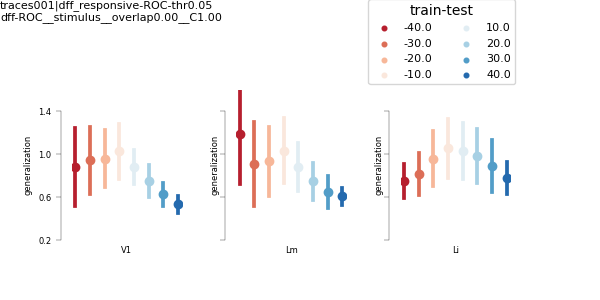

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_ncells/morphlevel/size_single/dff-ROC__stimulus__overlap0.00__C1.00 generalization_split_traintest__dff-ROC__stimulus__overlap0.00__C1.00


In [185]:
metric='generalization'
size_metric='train_test_diff'
multi_comp_test='fdr_bh'

curr_ncells=max_ncells

print(datameans_per_iter.groupby(['visual_area'])[metric].mean().round(3))
print(datameans_per_iter.groupby(['visual_area'])[metric].std().round(3))

plotd = datameans_per_iter[(datameans_per_iter.novel) 
                         & (datameans_per_iter['n_cells']==curr_ncells)].copy()

diff_palette = 'Greys' if size_metric=='train_test_abs' else 'RdBu'

#fig, axn = pl.subplots(1,2, figsize=(6.5,3), dpi=dpi, sharex=True, sharey=False)
fig, axn = pl.subplots(1, 3, figsize=(6,3), sharex=True,sharey=True)

# PLOT 2
for va, vg in plotd.groupby(['visual_area']):
    ax = axn[visual_areas.index(va)]
    sns.pointplot(x=size_metric, y=metric, hue=size_metric, data=vg, ax=ax, 
             palette=diff_palette, scale=0.8, 
              dodge=0.5, join=False, ci='sd', markers='o')
    ax.legend_.remove()
    ax.set_yticks(np.linspace(0.2, 1.4, 4))
    ax.set_ylim([0.2, 1.6])    
    ax.set_xlabel(va)
axn[-1].legend(bbox_to_anchor=(1.1, 1.), loc='lower right', title='train-test', markerscale=0.5, fontsize=8,
         ncol=2)

pl.tight_layout()
pl.subplots_adjust(left=0.12, right=0.85, wspace=0.5, top=0.7, bottom=0.2)

sns.despine(bottom=True, offset=8, trim=True)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xticks([])

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
figname='generalization_split_traintest__%s' % aggr_id #% (dset_str, shuffle_str, errstr)
#figname='genratio_meanbyiter_split_traintransform__%s_%s_%s2' % (dset_str, shuffle_str, errstr)

pl.savefig(os.path.join(curr_dst_dir,  '%s.svg' % figname))
print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


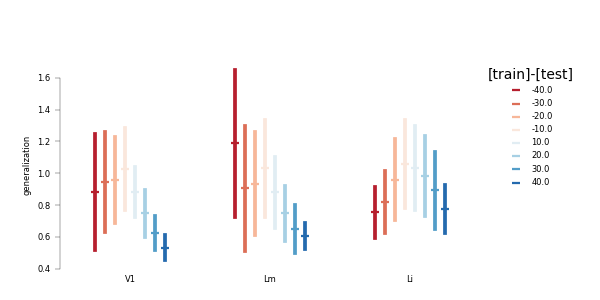

In [186]:
#fig, axn = pl.subplots(1,2, figsize=(6.5,3), dpi=dpi, sharex=True, sharey=False)
fig, ax = pl.subplots(figsize=(6,3))

# PLOT 2

sns.pointplot(x='visual_area', y=metric, data=plotd, ax=ax, 
           hue=size_metric, order=visual_areas, palette=diff_palette, scale=0.8, 
              dodge=0.5, join=False, ci='sd', markers='_')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
         title='[train]-[test]')
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.8)
sns.despine(bottom=True, trim=True)


In [115]:
import statsmodels.api as sm

In [ ]:
iterdf.

<IPython.core.display.Javascript object>


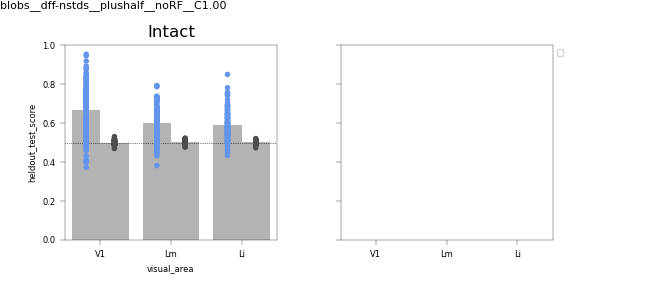

No handles with labels found to put in legend.


In [177]:
if analysis_type=='by_fov':
    bw_cond_colors = dict((k, [0.7]*3) for k in ['data', 'shuffled'])
    cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}


    fig, axn = pl.subplots(1,2, figsize=(6.5, 3), sharex=True, sharey=True)
    for ai, (is_intact, df) in enumerate(DF.groupby('intact')):
        ax=axn[ai]
        corr_str = 'Intact' if is_intact else 'No corrs.'
        ax.set_title(corr_str)
        sns.barplot(x='visual_area', y=metric, data=df, ax=ax,
                hue='condition', order=visual_areas, ci=None, palette=bw_cond_colors)
        sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
                hue='condition', order=visual_areas, palette=cond_colors,
                jitter=False, dodge=True, s=4)

        ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
    pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85,
                      wspace=0.3)

    pplot.label_figure(fig, aggr_id)
    figname = 'intact_vs_indep'
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [167]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov'

<IPython.core.display.Javascript object>


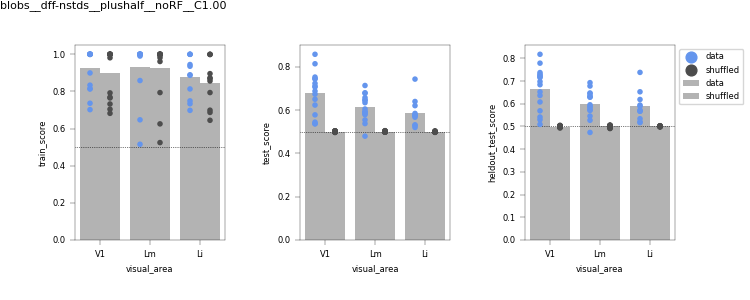

In [168]:
bw_cond_colors = dict((k, [0.7]*3) for k in ['data', 'shuffled'])
cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}

metric_list = ['train_score', 'test_score', 'heldout_test_score']

fig, axn = pl.subplots(1, len(metric_list), figsize=(2.5*len(metric_list), 3))
for ai, metric in enumerate(metric_list):
    ax=axn[ai]
    sns.barplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, ci=None, palette=bw_cond_colors)
    sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
            hue='condition', order=visual_areas, palette=cond_colors,
            jitter=False, dodge=True, s=4)
    
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.85,
                  wspace=0.5)

pplot.label_figure(fig, aggr_id)
figname = 'aggr_performance_metrics'
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [183]:
DF

,visual_area,datakey,condition,novel,train_transform,test_transform,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,n_trials,iteration,n_cells,intact
0,Li,20190422_JC076_fov1,data,False,10_20_30_40,10_20_30_40,0.011768,0.000475,0.526641,0.886592,0.011687,0.001365,0.016860,0.532917,1.0,4768.29,240.0,49.5,68.0,True
1,Li,20190422_JC076_fov1,data,False,10_20_30_50,10_20_30_50,0.011565,0.000462,0.536306,0.892078,0.009614,-0.001699,0.013870,0.537917,1.0,5212.13,240.0,49.5,68.0,True
2,Li,20190422_JC076_fov1,data,False,10_20_40_50,10_20_40_50,0.011347,0.000465,0.538179,0.895239,0.012811,0.002960,0.018483,0.543958,1.0,5011.99,240.0,49.5,68.0,True
3,Li,20190422_JC076_fov1,data,False,10_30_40_50,10_30_40_50,0.014093,0.000477,0.512409,0.872984,0.010969,0.000264,0.015826,0.523542,1.0,4847.80,240.0,49.5,68.0,True
4,Li,20190422_JC076_fov1,data,False,20_30_40_50,20_30_40_50,0.010543,0.000458,0.544619,0.900372,0.016351,0.008292,0.023590,0.552708,1.0,4803.09,240.0,49.5,68.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,V1,20191006_JC110_fov1,shuffled,False,10_20_30_40,10_20_30_40,0.005513,0.000721,0.496537,1.000000,0.009511,-0.000313,0.013722,0.493585,1.0,5074.57,264.0,49.5,221.0,True
626,V1,20191006_JC110_fov1,shuffled,False,10_20_30_50,10_20_30_50,0.005505,0.000725,0.507712,1.000000,0.012291,0.003762,0.017732,0.476226,1.0,5191.18,264.0,49.5,221.0,True
627,V1,20191006_JC110_fov1,shuffled,False,10_20_40_50,10_20_40_50,0.005547,0.000745,0.502377,1.000000,0.009419,-0.000424,0.013588,0.503962,1.0,5052.93,264.0,49.5,221.0,True
628,V1,20191006_JC110_fov1,shuffled,False,10_30_40_50,10_30_40_50,0.005608,0.000740,0.491905,1.000000,0.011515,0.002673,0.016613,0.510189,1.0,4996.48,264.0,49.5,221.0,True


<IPython.core.display.Javascript object>


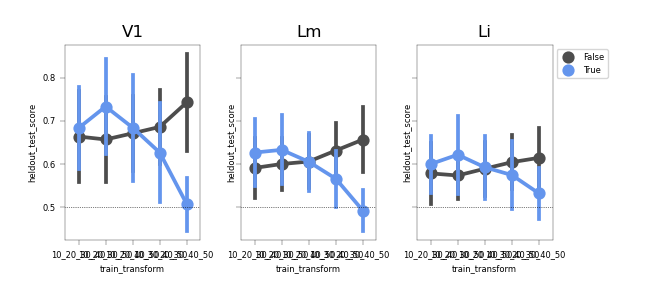

In [206]:
plotd = DF[DF.intact].copy()

keys = [True, False]
bw_cond_colors = dict((k, [0.7]*3) for k in keys)
#cond_colors = {'data': 'cornflowerblue', 'shuffled': [0.3]*3}
cond_colors = {keys[0]: 'cornflowerblue', keys[1]: [0.3]*3}

metric = 'heldout_test_score'
fig, axn = pl.subplots(1,3, figsize=(6.5, 3), sharex=True, sharey=True)
for vi, (va, df) in enumerate(DF.groupby('visual_area')):
    ai = visual_areas.index(va)
    ax=axn[ai]
    ax.set_title(va)
    sns.pointplot(x='train_transform', y=metric, data=df, ax=ax,
            hue='novel', ci='sd', palette=cond_colors)
#     sns.stripplot(x='visual_area', y=metric, data=df, ax=ax,
#             hue='condition', order=visual_areas, palette=cond_colors,
#             jitter=False, dodge=True, s=4)
    
    ax.axhline(y=chance_level, ls=':', c='k', lw=0.5)
    ax.legend_.remove()
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.85,
                  wspace=0.3)

# pplot.label_figure(fig, aggr_id)
# figname = 'intact_vs_indep'
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))